* *Installing Dependencies*...

In [5]:
!pip install gymnasium==0.29.1
!pip install shimmy==1.2.1
!pip install stable-baselines3==2.1.0
!pip install yfinance
!pip install ta
!pip install pandas numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.1.0
    Uninstalling gymnasium-1.1.0:
      Successfully uninstalled gymnasium-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
  

* *Importing Modules/Libraries*...

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium as gym
from gymnasium import spaces



------------

---



---





**Regime-Detection Function**

In [18]:
def detect_regime(data, rsi_window=14, macd_fast=12, macd_slow=26):
    # Always ensure 'Close' is a Series, not a DataFrame
    close_prices = data['Close'].squeeze()
    rsi = RSIIndicator(close_prices, window=rsi_window).rsi()
    macd = MACD(close_prices, window_fast=macd_fast, window_slow=macd_slow).macd_diff()
    conditions = [
        (rsi > 55) & (macd > 0),
        (rsi < 45) & (macd < 0),
        True
    ]
    choices = [0, 1, 2]  # 0=Bull, 1=Bear, 2=Sideways
    regime = pd.Series(np.select(conditions, choices), index=data.index)
    return regime

**Custom Gym Environment**

In [19]:
class MarketRegimePortfolioEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    def __init__(self, df, initial_balance=10000, lookback=30):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.lookback = lookback
        self.current_step = lookback
        self.initial_balance = initial_balance
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(lookback + 2,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)
        self.reset()
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.shares = 0
        self.portfolio_value = [self.initial_balance]
        self.current_step = self.lookback
        return self._get_obs(), {}
    def _get_obs(self):
        start_index = max(self.current_step - self.lookback, 0)
        # Always ensure 'Close' is a Series
        returns = self.df['Close'].squeeze().pct_change().iloc[start_index:self.current_step].fillna(0).values
        regime = self.df['Regime'].iloc[self.current_step]
        if len(returns) < self.lookback:
            padding_size = self.lookback - len(returns)
            returns = np.pad(returns, (padding_size, 0), 'constant', constant_values=0)
        return np.append(returns, [regime, self.shares / 100])
    def step(self, action):
        terminated = False
        truncated = False
        self.current_step += 1
        if self.current_step >= len(self.df):
            obs = self._get_obs()
            return obs, 0.0, True, False, {}
        current_price = self.df['Close'].squeeze().iloc[self.current_step]
        portfolio_val = self.balance + self.shares * current_price
        max_trade_value = portfolio_val * 0.2
        if action == 0 and self.shares > 0:
            shares_to_sell = min(self.shares, max_trade_value / current_price)
            self.balance += shares_to_sell * current_price
            self.shares -= shares_to_sell
        elif action == 2 and self.balance > 0:
            affordable_shares = min(self.balance / current_price, max_trade_value / current_price)
            self.shares += affordable_shares
            self.balance -= affordable_shares * current_price
        portfolio_value = self.balance + self.shares * current_price
        self.portfolio_value.append(portfolio_value)
        reward = 0
        if len(self.portfolio_value) > 1:
            reward = (self.portfolio_value[-1] / self.portfolio_value[-2] - 1) * 100
        if action == 1:
            regime = self.df['Regime'].iloc[self.current_step]
            if regime != 2:
                reward -= 0.1
        terminated = self.current_step >= len(self.df) - 1
        return self._get_obs(), reward, terminated, truncated, {}

**Reward-Logging Callback**

In [20]:
class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_reward = 0
    def _on_step(self) -> bool:
        self.episode_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
        return True

**Data Preparation**

In [21]:
def prepare_data(ticker='SPY', start='2010-01-01', end='2024-12-31'):
    data = yf.download(ticker, start=start, end=end)
    data['Close'] = data['Close'].squeeze()
    data['Regime'] = detect_regime(data)
    data = data.dropna().reset_index(drop=True)
    return data

**Static Buy and Hold Strategy**

In [22]:
def static_strategy(data, initial_balance=10000):
    shares = initial_balance / data['Close'].iloc[0]
    portfolio_values = shares * data['Close'].squeeze()
    return portfolio_values.values.tolist()

**Training the RL (Reinforcement Learning) Agent**

In [23]:
def train_agent(data, timesteps=50_000):
    env = MarketRegimePortfolioEnv(data)
    callback = RewardLoggingCallback()
    model = PPO('MlpPolicy', env, verbose=1, learning_rate=3e-4, n_steps=2048, batch_size=64)
    model.learn(total_timesteps=timesteps, callback=callback)
    return model, callback.episode_rewards

---
---
---

**Back-Testing the RL (Reinforcement Learning) Agent**

In [24]:
def backtest(model, data):
    env = MarketRegimePortfolioEnv(data)
    obs, _ = env.reset()
    done = False
    portfolio_values = [env.initial_balance]
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        portfolio_values.append(env.portfolio_value[-1])
    return portfolio_values

**Calculating Performance Metrics**

In [25]:
def calculate_metrics(portfolio):
    returns = pd.Series(portfolio).pct_change().dropna()
    total_return = (portfolio[-1] / portfolio[0] - 1) * 100
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    return total_return, volatility, sharpe_ratio

---
---
---

**Visualizations**

In [39]:
def plot_regimes(data):
    plt.figure(figsize=(14,4))
    plt.plot(data['Close'], label='Close Price', color='#1f77b4', linewidth=2)
    colors = ['#2ca02c', '#d62728', '#ff7f0e']  # Sleek, sophisticated color choices
    labels = ['Bull', 'Bear', 'Sideways']
    for regime in [0,1,2]:
        idx = data['Regime'] == regime
        plt.scatter(data.index[idx], data['Close'][idx], s=30, c=colors[regime], label=labels[regime], alpha=0.7, edgecolors='white', linewidth=1.2)
    plt.title('Price with Market Regimes', fontsize=16, fontweight='normal', color='#333333')
    plt.legend(facecolor='white', edgecolor='gray', fontsize=12, loc='upper left')
    plt.grid(True, linestyle='-', alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_training_rewards(rewards, window=50):
    if len(rewards) == 0:
        print("No rewards logged.")
        return
    rewards_series = pd.Series(rewards)
    smoothed = rewards_series.rolling(window).mean()
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_series, alpha=0.5, label='Episode Reward', color='#5a5a5a', linewidth=1)
    plt.plot(smoothed, label=f'Smoothed Reward (window={window})', color='#ff4c00', linewidth=3)
    plt.xlabel('Episode', fontsize=14, color='#333333')
    plt.ylabel('Reward', fontsize=14, color='#333333')
    plt.title('Training Episode Rewards', fontsize=16, fontweight='normal', color='#333333')
    plt.legend(facecolor='white', edgecolor='gray', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_portfolio_comparison(rl_pf, static_pf):
    min_len = min(len(rl_pf), len(static_pf))
    plt.figure(figsize=(14,6))
    plt.plot(rl_pf[:min_len], label='RL Portfolio', color='#9467bd', linewidth=2)
    plt.plot(static_pf[:min_len], label='Buy & Hold', color='#e377c2', linestyle='--', linewidth=2)
    plt.title('Portfolio Value Comparison', fontsize=16, fontweight='normal', color='#333333')
    plt.xlabel('Time Steps', fontsize=14, color='#333333')
    plt.ylabel('Portfolio Value', fontsize=14, color='#333333')
    plt.legend(facecolor='white', edgecolor='gray', fontsize=12)
    plt.grid(True, linestyle='-', alpha=0.2)
    plt.tight_layout()
    plt.show()

def plot_portfolio_returns(rl_pf, static_pf):
    min_len = min(len(rl_pf), len(static_pf))
    rl_returns = pd.Series(rl_pf[:min_len]).pct_change().dropna()
    static_returns = pd.Series(static_pf[:min_len]).pct_change().dropna()
    plt.figure(figsize=(14,4))
    plt.plot(rl_returns.cumsum(), label='Cumulative Returns RL', color='#2ca02c', linewidth=2)
    plt.plot(static_returns.cumsum(), label='Cumulative Returns Buy & Hold', color='#d62728', linestyle='--', linewidth=2)
    plt.title('Cumulative Returns Comparison', fontsize=16, fontweight='normal', color='#333333')
    plt.xlabel('Time Steps', fontsize=14, color='#333333')
    plt.ylabel('Cumulative Returns', fontsize=14, color='#333333')
    plt.legend(facecolor='white', edgecolor='gray', fontsize=12)
    plt.grid(True, linestyle='-', alpha=0.2)
    plt.tight_layout()
    plt.show()

---

**Main Executable Code (RUN)**

[*********************100%***********************]  1 of 1 completed


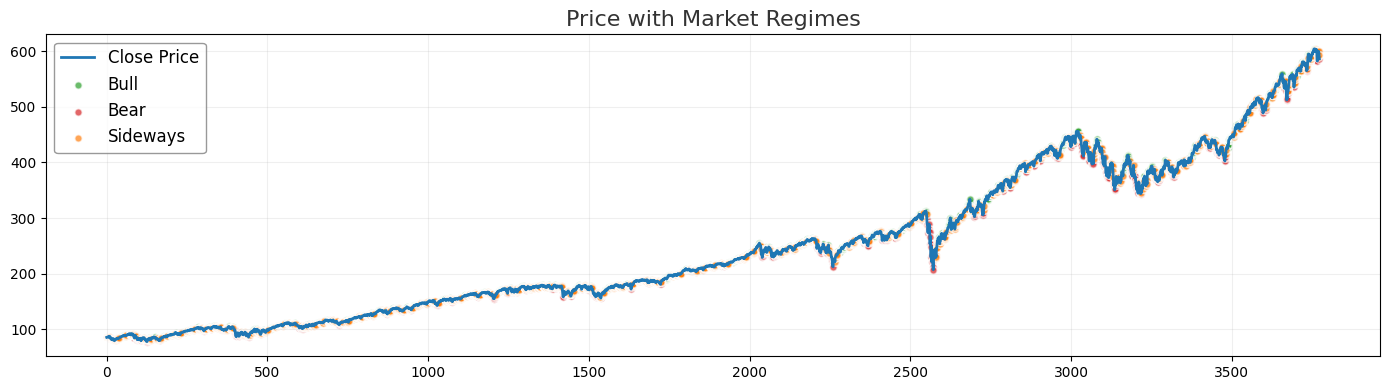

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 291  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.74e+03    |
|    ep_rew_mean          | 50.5        |
| time/                   |             |
|    fps                  | 250         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005255603 |
|    clip_fraction        | 0.0595      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0131     |
|    learning_rate        | 0.0003      |
|    loss               

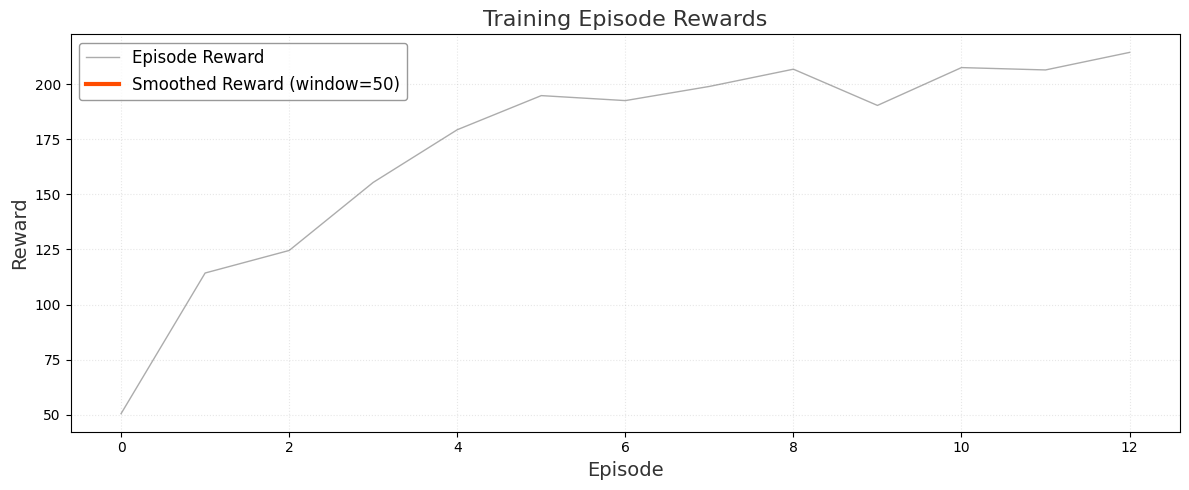

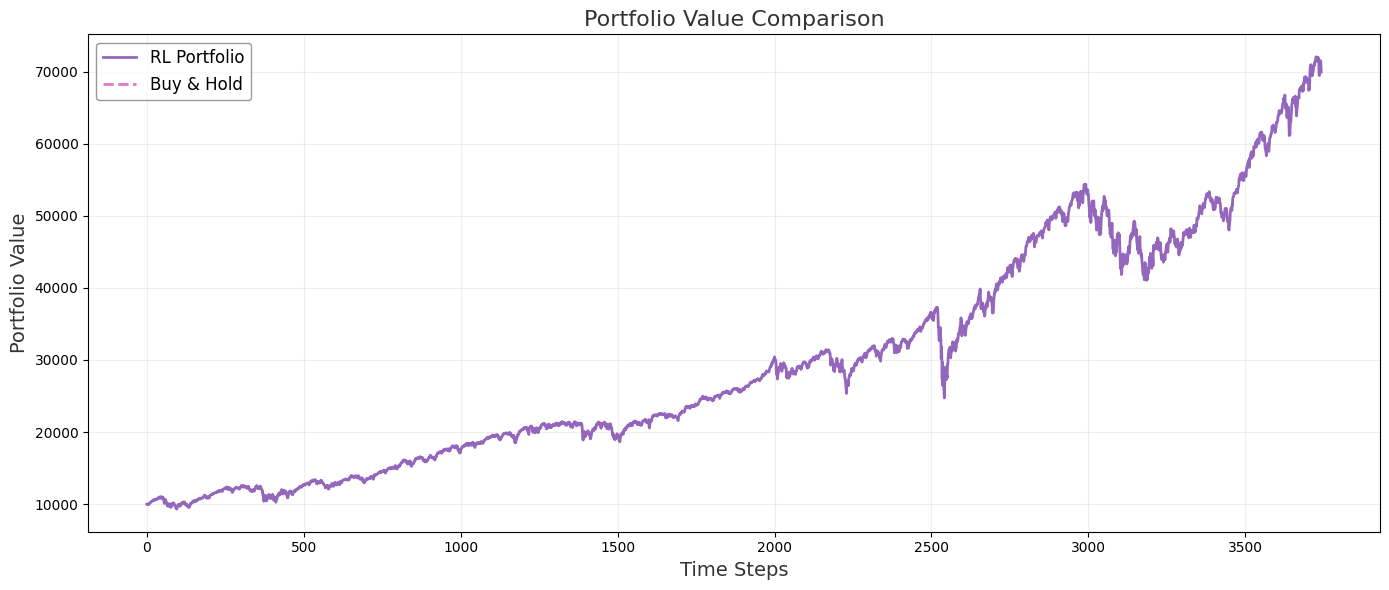

<ipython-input-39-69f7e7f9e8ea>:48: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  static_returns = pd.Series(static_pf[:min_len]).pct_change().dropna()


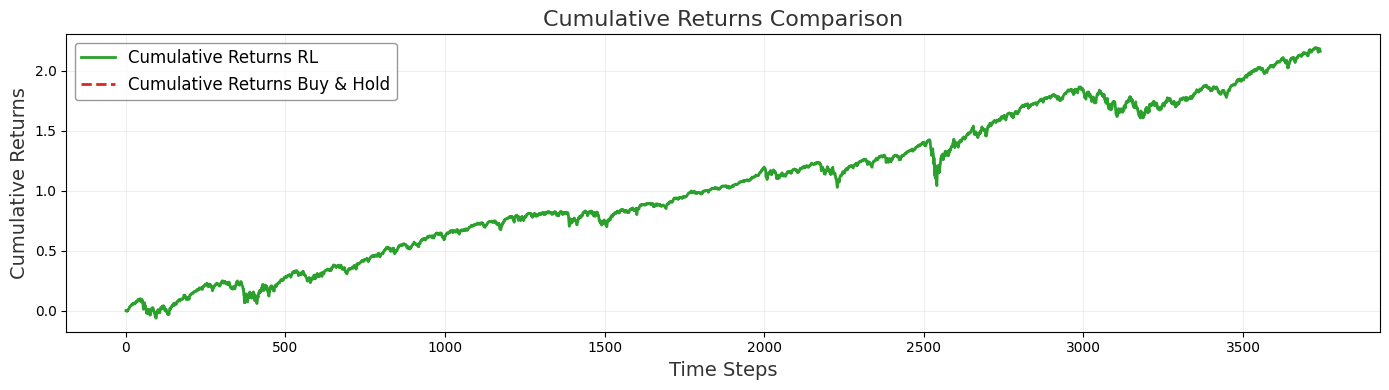

-------------------- RL Portfolio --------------------
Total Return: 599.59%
Volatility: 0.1704
Sharpe Ratio: 0.8544
-------------------- Buy & Hold --------------------
Total Return: nan%
Volatility: nan
Sharpe Ratio: nan


<ipython-input-25-761e7e08a7fd>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pd.Series(portfolio).pct_change().dropna()


In [40]:
if __name__ == "__main__":
    data = prepare_data()
    plot_regimes(data)
    static_pf = static_strategy(data)
    model, episode_rewards = train_agent(data, timesteps=50_000)
    plot_training_rewards(episode_rewards)
    rl_pf = backtest(model, data)
    plot_portfolio_comparison(rl_pf, static_pf)
    plot_portfolio_returns(rl_pf, static_pf)
    rl_total_return, rl_volatility, rl_sharpe_ratio = calculate_metrics(rl_pf)
    static_total_return, static_volatility, static_sharpe_ratio = calculate_metrics(static_pf)
    print("-------------------- RL Portfolio --------------------")
    print(f"Total Return: {rl_total_return:.2f}%")
    print(f"Volatility: {rl_volatility:.4f}")
    print(f"Sharpe Ratio: {rl_sharpe_ratio:.4f}")
    print("-------------------- Buy & Hold --------------------")
    print(f"Total Return: {static_total_return:.2f}%")
    print(f"Volatility: {static_volatility:.4f}")
    print(f"Sharpe Ratio: {static_sharpe_ratio:.4f}")